In [ ]:
# Standard libraries
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter

# For coord projections
import pyproj

# For plotting (maps)
# import pygmt
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt

# for mesh, forward modeling and inversion
from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz
from simpeg.utils import plot2Ddata, model_builder
from simpeg import maps
from simpeg.potential_fields import gravity
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
import choclo


## Synthetic Model

### Define a Tree Mesh

/var/folders/kv/9c2wczl17lzbpv6zgms9ms480000gn/T/ipykernel_16119/616903934.py:43: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  mesh = TreeMesh([hx, hy, hz], x0=[mesh_min_x, mesh_min_y, -z_length])


Text(0.5, 1.0, 'Cell Log-Volumes at Y = 0 m')

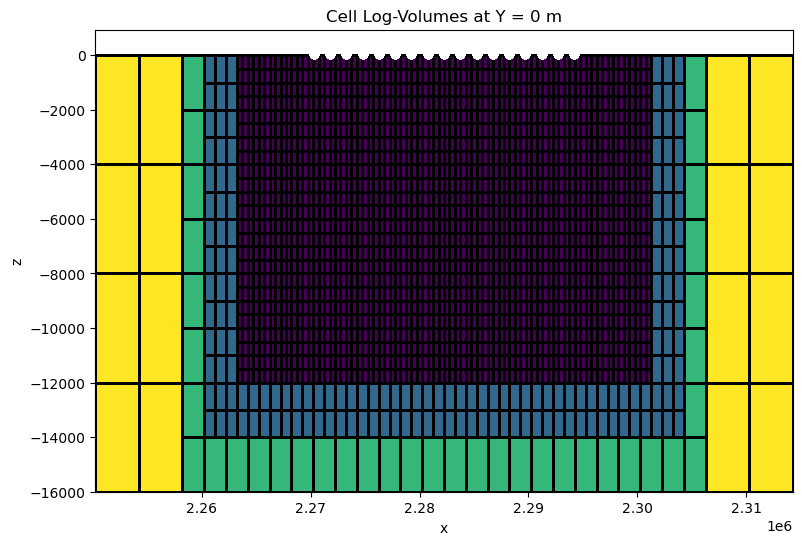

In [ ]:
# Set cell parameters
dx = 500  # minimum cell width (base mesh cell width) in x (in metres)
dy = 500  # minimum cell width (base mesh cell width) in y (in metres)
dz = 500  # minimum cell width (base mesh cell width) in z (in metres)

## calculate center of measurement points in horizontal direction
center_meas_x = np.min(grav_east) + (np.max(grav_east) - np.min(grav_east)) / 2.0
center_meas_y = np.min(grav_north) + (np.max(grav_north) - np.min(grav_north)) / 2.0

# set padding
pad_x = 11000
pad_y = 11000

# set mesh limits
mesh_min_x = np.min(grav_east) - pad_x
mesh_max_x = np.max(grav_east) + pad_x # such that the max points in x direction are equally far from the border of the mesh as the min points
mesh_min_y = np.min(grav_north) - pad_y
mesh_max_y = np.max(grav_north) + pad_y # such that the max points in x direction are equally far from the border of the mesh as the min points

# calculate the domain width
x_length = mesh_max_x - mesh_min_x  # domain width in x (in metres)
y_length = mesh_max_y - mesh_min_y  # domain width in y (in metres)
z_length = 22000.0  # domain width in z (in metres)

# Compute number of base mesh cells required in x and y
nbcx = 2 ** int(np.round(np.log(x_length / dx) / np.log(2.0)))
nbcy = 2 ** int(np.round(np.log(y_length / dy) / np.log(2.0)))
nbcz = 2 ** int(np.round(np.log(z_length / dz) / np.log(2.0)))

# recalculate domain widths in horizontal direction to make the mesh symmetric around the measurement points
x_length = nbcx * dx
y_length = nbcy * dy
z_length = nbcz * dz

# re-calculate the mesh limits in horizontal direction such that the measurement points are in the center and the mesh is symmetric around them
mesh_min_x = center_meas_x -x_length / 2.0 
mesh_min_y = center_meas_y -y_length / 2.0 

# Define the base mesh
hx = [(dx, nbcx)]
hy = [(dy, nbcy)]
hz = [(dz, nbcz)]
mesh = TreeMesh([hx, hy, hz], x0=[mesh_min_x, mesh_min_y, -z_length])

padding = [[2,2,2], [2,2,2]]

# # refine mesh downwards
# xyz_topo = np.c_[mkvc(bathy_east), mkvc(bathy_north), mkvc(bathymetry_ellips.values)]
# mesh.refine_surface(xyz_topo, padding_cells_by_level=padding, finalize=False)

# Refine the mesh downward below data points
xp, yp, zp = np.meshgrid([np.min(grav_east)-(pad_x/2), np.max(grav_east)+(pad_x/2)], [np.min(grav_north)-(pad_y/2), np.max(grav_north)+(pad_y/2)], [-10000,0])
box = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
mesh.refine_bounding_box(box, padding_cells_by_level=padding, finalize=False)

# # Refine the mesh near gravity data points
# xp, yp, zp = np.meshgrid([mesh_min_x, mesh_max_x], [mesh_min_y, mesh_max_y], [-10000,0])
# box = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
# mesh.refine_bounding_box(box, padding_cells_by_level=padding, finalize=False)

mesh.finalize()

# The bottom west corner
x0 = mesh.x0

# The total number of cells
nC = mesh.nC

# An (nC, 3) array containing the cell-center locations
cc = mesh.gridCC

# A boolean array specifying which cells lie on the boundary
bInd = mesh.cell_boundary_indices

# Cell volumes
v = mesh.cell_volumes

## plot the mesh in terms of cell volume
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
mesh.plot_slice(np.log10(v), normal="Y", ax=ax, ind=int(mesh.h[1].size / 2), grid=True)
ax.scatter(grav_east, meas_height_ellips.values, c='w', zorder=3) # # this is not quite correct yet, need to choose the slice of the grid
ax.set_title("Cell Log-Volumes at Y = 0 m")


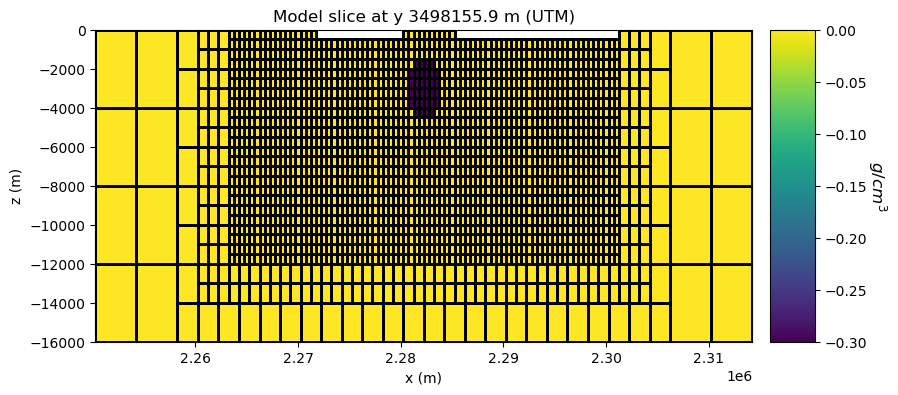

In [ ]:
# Define density contrast values for each unit in g/cc
background_density = 0.0
sphere_density = -0.3

# Find the indices for the active mesh cells (e.g. cells below surface)
ind_active = active_from_xyz(mesh, xyz_topo)

# Define mapping from model to active cells. The model consists of a value for
# each cell below the Earth's surface.
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model will be value of active cells

# Define model
true_model = background_density * np.ones(nC)

# add a spherical magma chamber
ind_sphere = model_builder.get_indices_sphere(
    np.r_[center_meas_x, center_meas_y, -3000.0], 1500.0, mesh.gridCC
)
ind_sphere = ind_sphere[ind_active]
true_model[ind_sphere] = sphere_density

## Plot Density Contrast Model ##
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plot_slice(
    plotting_map * true_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.h[1].size / 2),
    grid=True,
    clim=(np.min(true_model), np.max(true_model)),
    pcolor_opts={"cmap": "viridis"},
)
ax1.set_title(f"Model slice at y {center_meas_y:.1f} m (UTM)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(true_model), vmax=np.max(true_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()

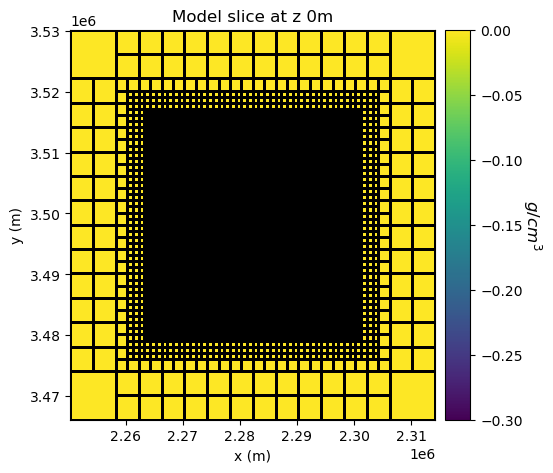

In [ ]:
## Plot Density Contrast Model ##
fig = plt.figure(figsize=(5, 5))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plot_slice(
    plotting_map * true_model,
    normal="Z",
    ax=ax1,
    ind=len(mesh.h[2])-7,
    grid=True,
    clim=(np.min(true_model), np.max(true_model)),
    pcolor_opts={"cmap": "viridis"}
)
ax1.set_title(f"Model slice at z 0m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(true_model), vmax=np.max(true_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()

### Forward calculation based on synthetic model

In [ ]:
receiver_locations = np.c_[mkvc(grav_east), mkvc(grav_north), mkvc(meas_height_ellips.values)]

# Define the component(s) of the field we want to simulate as strings within
# a list. Here we measure the x, y and z components of the gravity anomaly at
# each observation location.
components = ["gx", "gy", "gz"]

# Use the observation locations and components to define the receivers. To
# simulate data, the receivers must be defined as a list.
receiver_list = gravity.receivers.Point(receiver_locations, components=components)

receiver_list = [receiver_list]

# Defining the source field.
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Defining the survey
survey = gravity.survey.Survey(source_field)

In [ ]:
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    rhoMap=model_map,
    active_cells=ind_active,
    store_sensitivities="forward_only",
    engine="choclo" 
)

In [ ]:
dobs_syn = simulation.dpred(true_model)
n_data = len(dobs_syn)

# assigning uncertainties
maximum_anomaly = np.max(np.abs(dobs_syn))
uncertainties = 0.01 * maximum_anomaly * np.ones(np.shape(dobs_syn))

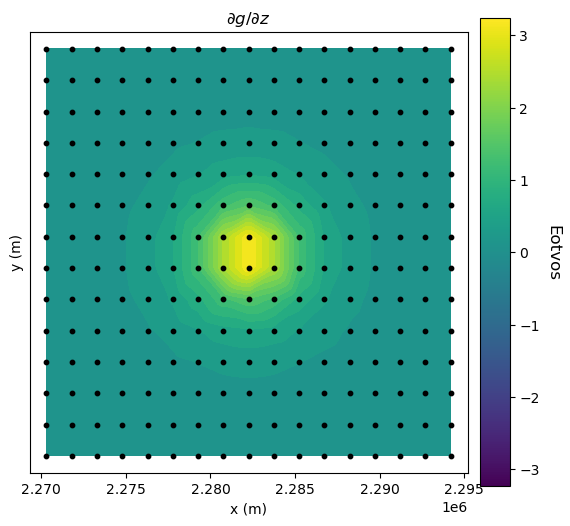

In [ ]:
fig = plt.figure(figsize=(6, 6))
n_locations = receiver_locations.shape[0]
v_max = np.max(np.abs(dobs_syn))

ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
cplot3 = plot2Ddata(
    receiver_locations,
    dobs_syn[2:n_data:3],
    ax=ax1,
    ncontour=30,
    clim=(-v_max, v_max),
    contourOpts={"cmap": "viridis"},
)
cplot3[0].set_clim((-v_max, v_max))
ax1.scatter(
    receiver_locations[:, 0],
    receiver_locations[:, 1],
    c="k",
    s=10,
    zorder=3,
)
x_range = ax1.get_xlim()
ax1.set_xlim(x_range[0] - 1000, x_range[1] + 1000)
y_range = ax1.get_ylim()
ax1.set_ylim(y_range[0] - 1000, y_range[1] + 1000)
ax1.set_title(r"$\partial g /\partial z$")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")
ax1.set_yticks([])

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap='viridis'
)
cbar.set_label("Eotvos", rotation=270, labelpad=15, size=12)

plt.show()

### Inversion with synthetic data

In [ ]:
# Find the indices of the active cells in forward model (ones below surface)
ind_active = active_from_xyz(mesh, xyz_topo)

# Define mapping from model to active cells
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model consists of a value for each active cell

# Define and plot starting model
starting_model = np.zeros(nC)

In [ ]:
# define the data object that is inverted
data_object = data.Data(survey, dobs=dobs_syn, standard_deviation=uncertainties)
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)

# Define the regularization (model objective function).
reg = regularization.WeightedLeastSquares(
    mesh, active_cells=ind_active, mapping=model_map
)

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=10, lower=-1.0, upper=1.0, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [ ]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Defining the fractional decrease in beta and the number of Gauss-Newton solves
# for each beta value.
beta_schedule = directives.BetaSchedule(coolingFactor=5, coolingRate=1)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)

# The directives are defined as a list.
directives_list = [
    sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    update_jacobi,
    target_misfit,
]

In [ ]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.23.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    


/Users/kmaetschke/PhD/.conda/lib/python3.12/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.99e-02  2.73e+04  0.00e+00  2.73e+04    3.37e+02      0              
   1  7.98e-03  1.38e+04  1.31e+05  1.49e+04    2.75e+02      0              
   2  1.60e-03  3.96e+03  7.08e+05  5.09e+03    2.01e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.7294e+03
0 : |xc-x_last| = 5.0302e-01 <= tolX*(1+|x0|) = 1.0000e-01
0 : |proj(x-g)-x|    = 2.0045e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 2.0045e+02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      10    <= iter          =      3
------------------------- DONE! -------------------------


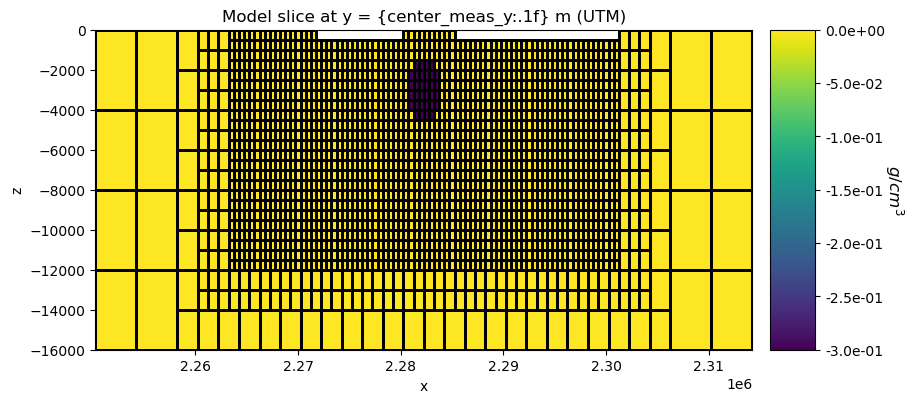

NameError: name 'recovered_model' is not defined

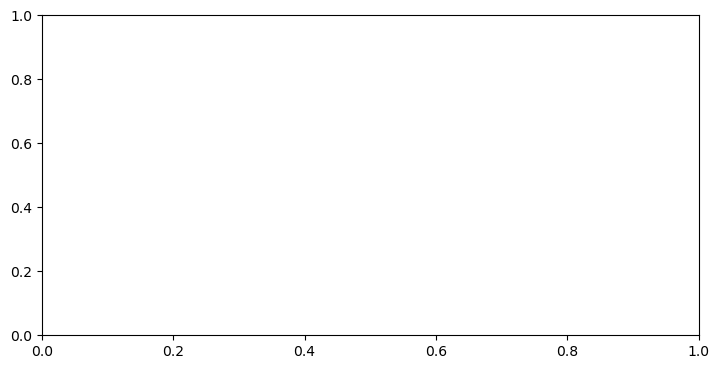

In [ ]:
# Plot True Model
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
mesh.plot_slice(
    plotting_map * true_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=True,
    clim=(np.min(true_model), np.max(true_model)),
    pcolor_opts={"cmap": "viridis"},
)
ax1.set_title("Model slice at y = {center_meas_y:.1f} m (UTM)")


ax2 = fig.add_axes([0.85, 0.1, 0.05, 0.8])
norm = mpl.colors.Normalize(vmin=np.min(true_model), vmax=np.max(true_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis, format="%.1e"
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()

# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
mesh.plot_slice(
    plotting_map * recovered_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=True,
    clim=(np.min(recovered_model), np.max(recovered_model)),
    pcolor_opts={"cmap": "viridis"},
)
ax1.set_title("Model slice at {center_meas_y:.1f} m (UTM)")

ax2 = fig.add_axes([0.85, 0.1, 0.05, 0.8])
norm = mpl.colors.Normalize(vmin=np.min(true_model), vmax=np.max(true_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()

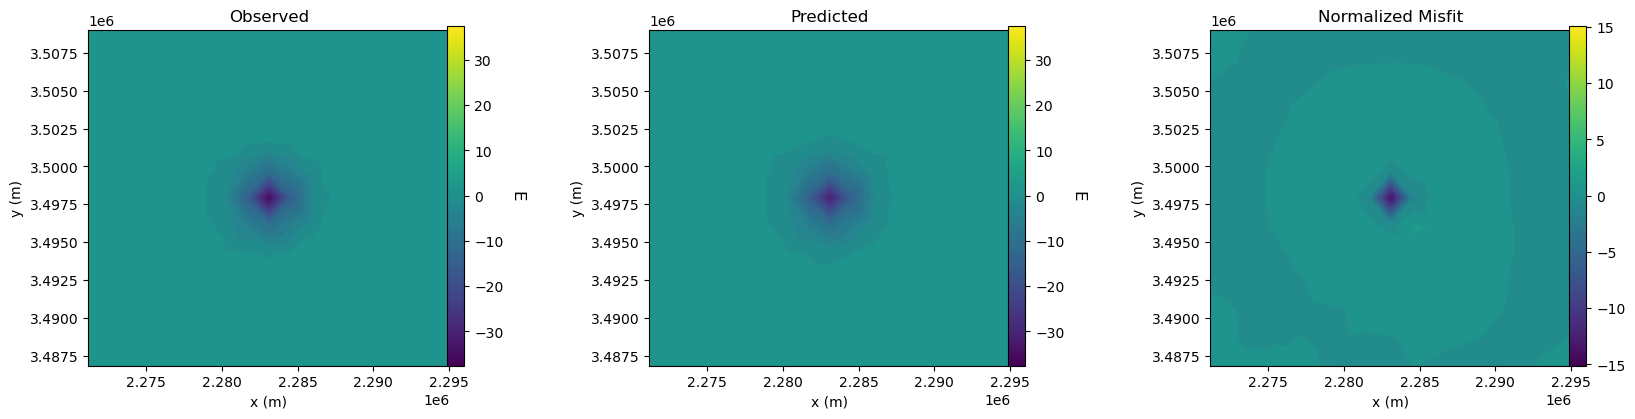

In [ ]:
# Predicted data with final recovered model
# SimPEG uses right handed coordinate where Z is positive upward.
# This causes gravity signals look "inconsistent" with density values in visualization.
dpred = inv_prob.dpred

# Observed data | Predicted data | Normalized data misfit
data_array = np.c_[dobs_syn, dpred, (dobs_syn - dpred) / uncertainties]

fig = plt.figure(figsize=(17, 4))
plot_title = ["Observed", "Predicted", "Normalized Misfit"]
plot_units = ["E", "E", ""]

ax1 = 3 * [None]
ax2 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]
v_lim = [np.max(np.abs(dobs_syn)), np.max(np.abs(dobs_syn)), np.max(np.abs(data_array[:, 2]))]


for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.33 * ii + 0.03, 0.11, 0.23, 0.84])
    cplot[ii] = plot2Ddata(
        receiver_list[0].locations,
        data_array[2:n_data:3, ii],
        ax=ax1[ii],
        ncontour=30,
        clim=(-v_lim[ii], v_lim[ii]),
        contourOpts={"cmap": "viridis"},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("x (m)")
    ax1[ii].set_ylabel("y (m)")

    ax2[ii] = fig.add_axes([0.33 * ii + 0.25, 0.11, 0.01, 0.85])
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="vertical", cmap='viridis'
    )
    cbar[ii].set_label(plot_units[ii], rotation=270, labelpad=15, size=12)

plt.show()

### Inversion with real data

Define a Tree mesh

/var/folders/kv/9c2wczl17lzbpv6zgms9ms480000gn/T/ipykernel_16119/2457061604.py:43: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  mesh = TreeMesh([hx, hy, hz], x0=[mesh_min_x, mesh_min_y, -z_length])


Text(0.5, 1.0, 'Cell Log-Volumes at Y = 0 m')

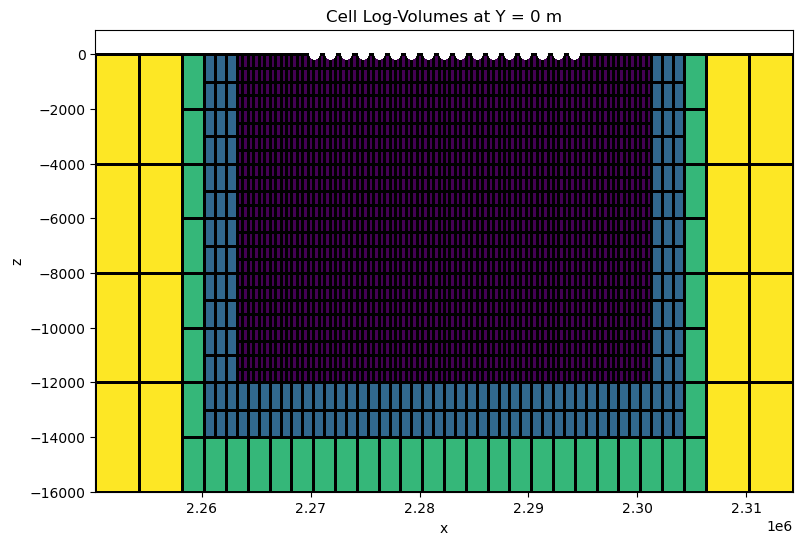

In [ ]:
# Set cell parameters
dx = 500  # minimum cell width (base mesh cell width) in x (in metres)
dy = 500  # minimum cell width (base mesh cell width) in y (in metres)
dz = 500  # minimum cell width (base mesh cell width) in z (in metres)

## calculate center of measurement points in horizontal direction
center_meas_x = np.min(grav_east) + (np.max(grav_east) - np.min(grav_east)) / 2.0
center_meas_y = np.min(grav_north) + (np.max(grav_north) - np.min(grav_north)) / 2.0

# set padding
pad_x = 11000
pad_y = 11000

# set mesh limits
mesh_min_x = np.min(grav_east) - pad_x
mesh_max_x = np.max(grav_east) + pad_x # such that the max points in x direction are equally far from the border of the mesh as the min points
mesh_min_y = np.min(grav_north) - pad_y
mesh_max_y = np.max(grav_north) + pad_y # such that the max points in x direction are equally far from the border of the mesh as the min points

# calculate the domain width
x_length = mesh_max_x - mesh_min_x  # domain width in x (in metres)
y_length = mesh_max_y - mesh_min_y  # domain width in y (in metres)
z_length = 22000.0  # domain width in z (in metres)

# Compute number of base mesh cells required in x and y
nbcx = 2 ** int(np.round(np.log(x_length / dx) / np.log(2.0)))
nbcy = 2 ** int(np.round(np.log(y_length / dy) / np.log(2.0)))
nbcz = 2 ** int(np.round(np.log(z_length / dz) / np.log(2.0)))

# recalculate domain widths in horizontal direction to make the mesh symmetric around the measurement points
x_length = nbcx * dx
y_length = nbcy * dy
z_length = nbcz * dz

# re-calculate the mesh limits in horizontal direction such that the measurement points are in the center and the mesh is symmetric around them
mesh_min_x = center_meas_x -x_length / 2.0 
mesh_min_y = center_meas_y -y_length / 2.0 

# Define the base mesh
hx = [(dx, nbcx)]
hy = [(dy, nbcy)]
hz = [(dz, nbcz)]
mesh = TreeMesh([hx, hy, hz], x0=[mesh_min_x, mesh_min_y, -z_length])

padding = [[2,2,2], [2,2,2]]

# # refine mesh downwards
# xyz_topo = np.c_[mkvc(bathy_easting), mkvc(bathy_northing), mkvc(bathymetry.values)]
# mesh.refine_surface(xyz_topo, padding_cells_by_level=padding, finalize=False)

# Refine the mesh downward below data points
xp, yp, zp = np.meshgrid([np.min(grav_east)-(pad_x/2), np.max(grav_east)+(pad_x/2)], [np.min(grav_north)-(pad_y/2), np.max(grav_north)+(pad_y/2)], [-10000,0])
box = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
mesh.refine_bounding_box(box, padding_cells_by_level=padding, finalize=False)

# # Refine the mesh near gravity data points
# xp, yp, zp = np.meshgrid([mesh_min_x, mesh_max_x], [mesh_min_y, mesh_max_y], [-10000,0])
# box = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
# mesh.refine_bounding_box(box, padding_cells_by_level=padding, finalize=False)

mesh.finalize()

# The bottom west corner
x0 = mesh.x0

# The total number of cells
nC = mesh.nC

# An (nC, 3) array containing the cell-center locations
cc = mesh.gridCC

# A boolean array specifying which cells lie on the boundary
bInd = mesh.cell_boundary_indices

# Cell volumes
v = mesh.cell_volumes

## plot the mesh in terms of cell volume
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
mesh.plot_slice(np.log10(v), normal="Y", ax=ax, ind=int(mesh.h[1].size / 2), grid=True)
ax.scatter(grav_east, meas_height_geoid_proj, c='w', zorder=3) # this is not quite correct yet, need to choose the slice of the grid
ax.set_title("Cell Log-Volumes at Y = 0 m")


In [ ]:
dobs = mkvc(gravity_residual_mgal.values)
n_data = len(dobs)

# setting uncertainties
maximum_anomaly = np.max(np.abs(dobs))
uncertainties = 0.01 * maximum_anomaly * np.ones(np.shape(dobs))

In [ ]:
receiver_locations = np.c_[mkvc(grav_east), mkvc(grav_north), mkvc(meas_height_geoid_proj.values)]

# Define the receivers. The data consists of vertical gravity anomaly measurements.
# The set of receivers must be defined as a list.
receiver_list = gravity.receivers.Point(receiver_locations, components="gz")

receiver_list = [receiver_list]

# Define the source field
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define the survey
survey = gravity.survey.Survey(source_field)

In [ ]:
# Find the indices of the active cells in forward model (ones below surface)
ind_active = active_from_xyz(mesh, xyz_topo)

# Define mapping from model to active cells
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model consists of a value for each active cell

# Define and plot starting model
starting_model = np.zeros(nC)

In [ ]:
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    rhoMap=model_map,
    active_cells=ind_active,
    store_sensitivities="forward_only",
    engine="choclo"
)

In [ ]:
# define the data object that is inverted
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)

# Define the regularization (model objective function).
reg = regularization.WeightedLeastSquares(
    mesh, active_cells=ind_active, mapping=model_map
)

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=20, lower=-1.0, upper=1.0, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [ ]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Defining the fractional decrease in beta and the number of Gauss-Newton solves
# for each beta value.
beta_schedule = directives.BetaSchedule(coolingFactor=5, coolingRate=1)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)

# The directives are defined as a list.
directives_list = [
    sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    update_jacobi,
    target_misfit,
]

In [ ]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.23.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    


/Users/kmaetschke/PhD/.conda/lib/python3.12/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  9.24e-04  2.80e+05  0.00e+00  2.80e+05    3.80e+02      0              
   1  1.85e-04  1.63e+05  5.28e+07  1.73e+05    3.73e+02      0              
   2  3.70e-05  5.91e+04  3.16e+08  7.08e+04    3.58e+02      0   Skip BFGS  
   3  7.39e-06  1.59e+04  8.09e+08  2.19e+04    3.16e+02      0   Skip BFGS  
   4  1.48e-06  3.61e+03  1.51e+09  5.84e+03    2.17e+02      0   Skip BFGS  
   5  2.96e-07  4.72e+02  2.36e+09  1.17e+03    1.17e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.7996e+04
0 : |xc-x_last| = 1.7885e+00 <= tolX*(1+|x0|) = 1.0000e-01
0 : |proj(x-g)-x|    = 1.1583e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|   

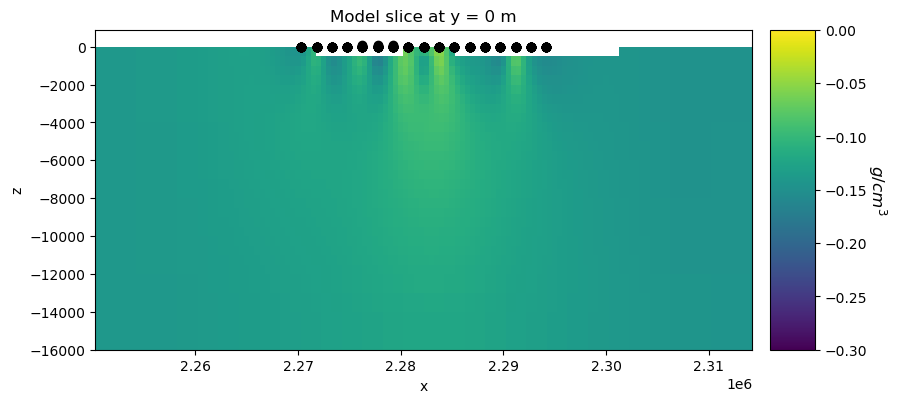

In [ ]:
# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
mesh.plot_slice(
    plotting_map * recovered_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    clim=(np.min(recovered_model), np.max(recovered_model)),
    pcolor_opts={"cmap": "viridis"},
)
ax1.scatter(grav_east, meas_height_geoid_proj, c='k', zorder=3) # this is not quite correct yet, need to choose the slice of the grid
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.05, 0.8])
norm = mpl.colors.Normalize(vmin=np.min(true_model), vmax=np.max(true_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()

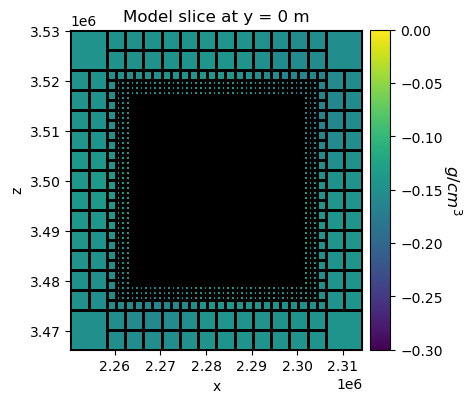

In [ ]:
# Plot Recovered Model
fig = plt.figure(figsize=(4, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
mesh.plot_slice(
    plotting_map * recovered_model,
    normal="Z",
    ax=ax1,
    ind=int(mesh.shape_cells[2] / 2),
    grid=True,
    clim=(np.min(recovered_model), np.max(recovered_model)),
    pcolor_opts={"cmap": "viridis"},
)
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.05, 0.8])
norm = mpl.colors.Normalize(vmin=np.min(true_model), vmax=np.max(true_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()